In [53]:
from typing import List, Dict, Iterable, Tuple, Callable
from matplotlib import pyplot as plt
from collections import Counter
# import pygal
import sys
import os
import string
import urllib.request
import requests
import curl
import pycurl
import webbrowser
import numpy as np
import math
import pandas as pd
# from IPython import qt
from matplotlib.pyplot import figure
from py.xml import raw
from requests.api import get
from matplotlib import pyplot as plt
# from scratch.working_with_data import rescale
# from scratch.multiple_regression import least_squares_fit, predict
# from scratch.gradient_descent import gradient_step

# from stats import mean, median, de_mean, standard_deviation, correlation
# from gradient_descent import minimize_stochastic, maximize_stochastic, maximize_batch
# from vector import dot, vector_add
# from normal import normal_cdf
# from matrix import make_matrix, get_column, shape, matrix_multiply
# from logistic_regression import *

import math
import os
import random
import sys
from functools import partial, reduce

from scipy.optimize import fmin_tnc

import tqdm

from typing import*

from collections import*
# from scipy import*
from sklearn.metrics import*

from numpy import *

# import mlxtend

# bltin_sum = np.sum

In [54]:
# Functions

# def add(a, b): return a + b

def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = np.sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = len(data[0])
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = len(data[0])
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -math.log(logistic(dot(x, beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test
                                                                



In [55]:
df = pd.read_csv('iris.dat', names=[
  "sepal length in cm",
  "sepal width in cm",
  "petal length in cm",
  "petal width in cm",
  "class"
])

In [56]:
df.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [57]:
# Identify classes
cls = []
for i in range(len(df['class'])):
    if df['class'][i] not in cls:
        cls.append(df['class'][i])


In [58]:
# Replace string with word
y = df['class']

for i in range(len(df['class'])):
    if y[i] == cls[0]:
        y[i] = 0
    elif y[i] == cls[1]:
        y[i] = 1
    elif y[i] == cls[2]:
        y[i] = 2
        


C:\Users\USER\AppData\Local\Temp/ipykernel_17656/2216541371.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i] = 0
C:\Users\USER\AppData\Local\Temp/ipykernel_17656/2216541371.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i] = 1
C:\Users\USER\AppData\Local\Temp/ipykernel_17656/2216541371.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i] = 2


In [59]:
# Break up into groups of petal length, petal width

# petal_length
# pl = df["petal length in cm"]
pl = df.iloc[:,2]
pw = df.iloc[:,3]

In [60]:
# Class 1
# p1_1 = df['class'][df['class'] == cls[0]]
df_class_1 = df.loc[df['class'] == 0]
# Petal Length
pl_1 = df_class_1[df_class_1.columns[2]]
pw_1 = df_class_1[df_class_1.columns[3]]

# Class 2
df_class_2 = df.loc[df['class'] == 1]
# Petal Length
pl_2 = df_class_2[df_class_2.columns[2]]
pw_2 = df_class_2[df_class_2.columns[3]]

# Class 3
df_class_3 = df.loc[df['class'] == 2]
# Petal Length
pl_3 = df_class_3[df_class_3.columns[2]]
pw_3 = df_class_3[df_class_3.columns[3]]


In [61]:
data_org_df = df[df.columns[2:5]]
data_org_np = data_org_df.to_numpy()
data_org_lst = data_org_np.tolist()
# data_org_lst

In [62]:
# def decision_boundary(data_df):
#     # Convert to list
#     data_org_np = data_df.to_numpy()
#     data_org_lst = data_org_np.tolist()
    
#     # Class
#     ys = [row[2] for row in data_org_lst if row[2] < 2]
    
#     # Input
#     xs = [[1] +row[:2] for row in data_org_lst if row[2] < 2]
    
#     # Maximum values
#     exp_val = data_df.iloc[:,0]
#     sal_val = data_df.iloc[:,1]
    
#     rescaled_xs = rescale(xs)
#     beta = least_squares_fit(rescaled_xs, ys, 0.001, 1000, 1)
#     predictions = [predict(x_i, beta) for x_i in rescaled_xs]
    
#     random.seed(0)
#     x_train, x_test, y_train, y_test = train_test_split(rescale_xs[0], ys, 0.33)
#     x_train

#     learning_rate = 0.01

#     # pick a random starting point
#     beta = [random.random() for _ in range(3)]
#     y_train

#     with tqdm.trange(2500) as t:
#         for epoch in t:
#             gradient = negative_log_gradient(x_train, y_train, beta)
#             beta = gradient_step(beta, gradient, -learning_rate)
#             loss = negative_log_likelihood(x_train, y_train, beta)
#             t.set_description(f"loss: {loss:.3f} beta: {beta}")

# #     print(t)

#     means, stdevs = scale(xs)
#     beta_unscaled = [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
#                      beta[1] / stdevs[1],
#                      beta[2] / stdevs[2]]
#     beta_unscaled

#     means, stdevs = scale(xs)
#     beta_unscaled = [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
#                      beta[1] / stdevs[1],
#                      beta[2] / stdevs[2]]
#     beta_unscaled
    
    
#     # min_range = (data_marks.min())
#     # min_range = math.floor(min_range[0])
#     # max_range = (data_marks.max())
#     # max_range = math.ceil(max_range[0])

#     min_val = math.floor(np.min(exp_val))
#     max_val = math.ceil(np.max(exp_val))

#     # x_db = [xi for xi in range(min_val,max_val)]
#     x_db = np.linspace(min_val,max_val,len(exp_val))
#     y_db = [(-beta_unscaled[1]/beta_unscaled[2]*xi - beta_unscaled[0]/beta_unscaled[2])
#             for xi in x_db]
#     return x_db,y_db

In [63]:
# y_db_1
len(cls)

3

In [64]:
# xs = [[1] +row[:2] for row in data_org_lst if row[2] < 2]
# xs
ys = [row[2] for row in data_org_lst if row[2] < 2]

xs_1 = []
# ys = df['class'].to_numpy().tolist()
# ys = []
for i in range(len(cls)-1):
    xs_0 = [[1] +row[:2] for row in data_org_lst if row[2] >= 0+i  and row[2] < len(cls) - 1+i]
#     ys_0 = [row[2] for row in data_org_lst if row[2] > 0+i and row[2] < 2+i]
    xs_1.append(xs_0)
#     ys.append(ys_0)
  
xs = xs_1[1]

# Maximum values
exp_val = data_org_df.iloc[:,0]
sal_val = data_org_df.iloc[:,1]

# onesx = np.ones((len(data_org_lst),1))
# xs = np.vstack(onesx,


# for row in data_org_lst:
#     print(row[2])
# xs_1[2]
len(xs_1[0])
sal_val
xs_1

[[[1, 1.4, 0.2],
  [1, 1.4, 0.2],
  [1, 1.3, 0.2],
  [1, 1.5, 0.2],
  [1, 1.4, 0.2],
  [1, 1.7, 0.4],
  [1, 1.4, 0.3],
  [1, 1.5, 0.2],
  [1, 1.4, 0.2],
  [1, 1.5, 0.1],
  [1, 1.5, 0.2],
  [1, 1.6, 0.2],
  [1, 1.4, 0.1],
  [1, 1.1, 0.1],
  [1, 1.2, 0.2],
  [1, 1.5, 0.4],
  [1, 1.3, 0.4],
  [1, 1.4, 0.3],
  [1, 1.7, 0.3],
  [1, 1.5, 0.3],
  [1, 1.7, 0.2],
  [1, 1.5, 0.4],
  [1, 1.0, 0.2],
  [1, 1.7, 0.5],
  [1, 1.9, 0.2],
  [1, 1.6, 0.2],
  [1, 1.6, 0.4],
  [1, 1.5, 0.2],
  [1, 1.4, 0.2],
  [1, 1.6, 0.2],
  [1, 1.6, 0.2],
  [1, 1.5, 0.4],
  [1, 1.5, 0.1],
  [1, 1.4, 0.2],
  [1, 1.5, 0.1],
  [1, 1.2, 0.2],
  [1, 1.3, 0.2],
  [1, 1.5, 0.1],
  [1, 1.3, 0.2],
  [1, 1.5, 0.2],
  [1, 1.3, 0.3],
  [1, 1.3, 0.3],
  [1, 1.3, 0.2],
  [1, 1.6, 0.6],
  [1, 1.9, 0.4],
  [1, 1.4, 0.3],
  [1, 1.6, 0.2],
  [1, 1.4, 0.2],
  [1, 1.5, 0.2],
  [1, 1.4, 0.2],
  [1, 4.7, 1.4],
  [1, 4.5, 1.5],
  [1, 4.9, 1.5],
  [1, 4.0, 1.3],
  [1, 4.6, 1.5],
  [1, 4.5, 1.3],
  [1, 4.7, 1.6],
  [1, 3.3, 1.0],
  [1, 4.6, 1.3

In [65]:
# def decision_boundary(data_df,xs,ys):
#     # Convert to list
# #     data_org_np = data_df.to_numpy()
# #     data_org_lst = data_org_np.tolist()
    
#     # Class
# #     ys = [row[2] for row in data_org_lst if row[2] < 2]
    
#     # Input
# #     xs = [[1] +row[:2] for row in data_org_lst if row[2] < 2]
    
#     # Maximum values
#     exp_val = data_df.iloc[:,0]
#     sal_val = data_df.iloc[:,1]
    
#     rescaled_xs = rescale(xs)
#     beta = least_squares_fit(rescaled_xs, ys, 0.001, 1000, 1)
#     predictions = [predict(x_i, beta) for x_i in rescaled_xs]
    
#     random.seed(0)
#     x_train, x_test, y_train, y_test = train_test_split(rescale_xs[0], ys, 0.33)
#     x_train

#     learning_rate = 0.01

#     # pick a random starting point
#     beta = [random.random() for _ in range(3)]
#     y_train

#     with tqdm.trange(2500) as t:
#         for epoch in t:
#             gradient = negative_log_gradient(x_train, y_train, beta)
#             beta = gradient_step(beta, gradient, -learning_rate)
#             loss = negative_log_likelihood(x_train, y_train, beta)
#             t.set_description(f"loss: {loss:.3f} beta: {beta}")

# #     print(t)

#     means, stdevs = scale(xs)
#     beta_unscaled = [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
#                      beta[1] / stdevs[1],
#                      beta[2] / stdevs[2]]
#     beta_unscaled

#     means, stdevs = scale(xs)
#     beta_unscaled = [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
#                      beta[1] / stdevs[1],
#                      beta[2] / stdevs[2]]
#     beta_unscaled
    
    
#     # min_range = (data_marks.min())
#     # min_range = math.floor(min_range[0])
#     # max_range = (data_marks.max())
#     # max_range = math.ceil(max_range[0])

#     min_val = math.floor(np.min(exp_val))
#     max_val = math.ceil(np.max(exp_val))

#     # x_db = [xi for xi in range(min_val,max_val)]
#     x_db = np.linspace(min_val,max_val,len(exp_val))
#     y_db = [(-beta_unscaled[1]/beta_unscaled[2]*xi - beta_unscaled[0]/beta_unscaled[2])
#             for xi in x_db]
#     return x_db,y_db

In [66]:
# def decision_boundary(data_df,xs,ys):
#     # Convert to list
# #     data_org_np = data_df.to_numpy()
# #     data_org_lst = data_org_np.tolist()
    
#     # Class
# #     ys = [row[2] for row in data_org_lst if row[2] < 2]
    
#     # Input
# #     xs = [[1] +row[:2] for row in data_org_lst if row[2] < 2]
    
# #     # Maximum values
# #     exp_val = data_df.iloc[:,0]
# #     sal_val = data_df.iloc[:,1]
    
    
#     rescaled_xs = rescale(xs)
#     beta = least_squares_fit(rescaled_xs, ys, 0.001, 1000, 1)
#     predictions = [predict(x_i, beta) for x_i in rescaled_xs]
    
#     random.seed(0)
#     x_train, x_test, y_train, y_test = train_test_split(rescaled_xs, ys, 0.33)
#     x_train

#     learning_rate = 0.01

#     # pick a random starting point
#     beta = [random.random() for _ in range(3)]
#     y_train

#     with tqdm.trange(2500) as t:
#         for epoch in t:
#             gradient = negative_log_gradient(x_train, y_train, beta)
#             beta = gradient_step(beta, gradient, -learning_rate)
#             loss = negative_log_likelihood(x_train, y_train, beta)
#             t.set_description(f"loss: {loss:.3f} beta: {beta}")

# #     print(t)

#     means, stdevs = scale(xs)
#     beta_unscaled = [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
#                      beta[1] / stdevs[1],
#                      beta[2] / stdevs[2]]
#     beta_unscaled

#     means, stdevs = scale(xs)
#     beta_unscaled = [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
#                      beta[1] / stdevs[1],
#                      beta[2] / stdevs[2]]
#     beta_unscaled
    
    
#     # min_range = (data_marks.min())
#     # min_range = math.floor(min_range[0])
#     # max_range = (data_marks.max())
#     # max_range = math.ceil(max_range[0])

#     min_val = math.floor(np.min(exp_val))
#     max_val = math.ceil(np.max(exp_val))

#     # x_db = [xi for xi in range(min_val,max_val)]
#     x_db = np.linspace(min_val,max_val,len(exp_val))
#     y_db = [(-beta_unscaled[1]/beta_unscaled[2]*xi - beta_unscaled[0]/beta_unscaled[2])
#             for xi in x_db]
#     return x_db,y_db

In [67]:
# Convert to list
# data_org_np = data__org_df.to_numpy()
# data_org_lst = data_org_np.tolist()
    
    # Class
#     ys = [row[2] for row in data_org_lst if row[2] < 2]
    
    # Input
#     xs = [[1] +row[:2] for row in data_org_lst if row[2] < 2]
    
#     # Maximum values
#     exp_val = data_df.iloc[:,0]
#     sal_val = data_df.iloc[:,1]
def decision_boundary_2(data_df,xs,ys,label):
    cls = label

# xs_1 = []
# # ys = df['class'].to_numpy().tolist()
# # ys = []
# for i in range(len(cls)-1):
#     xs_0 = [[1] +row[:2] for row in data_org_lst if row[2] >= 0+i  and row[2] < len(cls) - 1+i]
# #     ys_0 = [row[2] for row in data_org_lst if row[2] > 0+i and row[2] < 2+i]
#     xs_1.append(xs_0)
# #     ys.append(ys_0)

    x_db_lst = []
    y_db_lst = []
    if len(xs_1) > 1:
        for i in range(len(cls)-1):             

            xs = xs_1[i]
            rescaled_xs = rescale(xs)
            beta = least_squares_fit(rescaled_xs, ys, 0.001, 1000, 1)
            predictions = [predict(x_i, beta) for x_i in rescaled_xs]

            random.seed(0)
            x_train, x_test, y_train, y_test = train_test_split(rescaled_xs, ys, 0.33)
            x_train

            learning_rate = 0.01

            # pick a random starting point
            beta = [random.random() for _ in range(3)]
            y_train

            with tqdm.trange(2500) as t:
                for epoch in t:
                    gradient = negative_log_gradient(x_train, y_train, beta)
                    beta = gradient_step(beta, gradient, -learning_rate)
                    loss = negative_log_likelihood(x_train, y_train, beta)
                    t.set_description(f"loss: {loss:.3f} beta: {beta}")

        #     print(t)

            means, stdevs = scale(xs)
            beta_unscaled = [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
                             beta[1] / stdevs[1],
                             beta[2] / stdevs[2]]
            beta_unscaled

            means, stdevs = scale(xs)
            beta_unscaled = [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
                             beta[1] / stdevs[1],
                             beta[2] / stdevs[2]]
            beta_unscaled


            # min_range = (data_marks.min())
            # min_range = math.floor(min_range[0])
            # max_range = (data_marks.max())
            # max_range = math.ceil(max_range[0])

            min_val = math.floor(np.min(exp_val))
            max_val = math.ceil(np.max(exp_val))

            # x_db = [xi for xi in range(min_val,max_val)]
            x_db = np.linspace(min_val,max_val,len(exp_val))
            x_db_lst.append(x_db)
            y_db = [(-beta_unscaled[1]/beta_unscaled[2]*xi - beta_unscaled[0]/beta_unscaled[2])
                    for xi in x_db]
            y_db_lst.append(y_db)
    return x_db_lst,y_db_lst

In [68]:
x_db_lst,y_db_lst = decision_boundary_2(data_org_df,xs_1,ys,cls)

C:\Users\USER\AppData\Local\Temp/ipykernel_17656/2746858823.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return sum(v_i * w_i for v_i, w_i in zip(v, w))
  0%|                                                                                                                                             | 0/2500 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp/ipykernel_17656/2746858823.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return [sum(vector[i] for vector in vectors)
C:\Users\USER\AppData\Local\Temp/ipykernel_17656/2746858823.py:164: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin in

In [69]:
# y_db_lst[0]

In [70]:
# x_db_1,y_db_1 = decision_boundary(data_org_df,xs_1[0],ys)
# x_db_2,y_db_2 = decision_boundary(data_org_df,xs_1[1],ys)

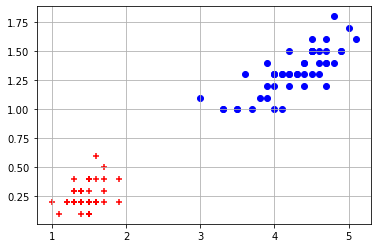

In [71]:
# Scatter Plots

plt.scatter(pl_1,pw_1, color = 'red', marker = '+')
plt.scatter(pl_2,pw_2, color = 'blue', marker = 'o')
# plt.scatter(pl_3,pw_3, color = 'green', marker = '*')
plt.grid()

plt.show()

In [72]:
# xs = [(1,) + row[:2] for row in data_org]
# ys = [row[2] for row in data_org]

In [73]:
# mm, nn = scale(xs)

In [74]:
# rescale_xs = []
# beta = []
# pred = []

# for i in range(len(cls)-2):
#     rescaled_xs = rescale(xs[i])
#     rescale_xs.append(rescaled_xs)
#     beta_0 = least_squares_fit(rescaled_xs, ys, 0.001, 1000, 1)
#     beta.append(beta_0)
#     predictions = [predict(x_i, beta_0) for x_i in rescaled_xs]
#     pred.append(predictions)

In [75]:
# rescaled_xs = rescale(xs_1[0])
# beta = least_squares_fit(rescaled_xs, ys, 0.001, 1000, 1)
# predictions = [predict(x_i, beta) for x_i in rescaled_xs]

In [76]:
# rescale_xs

In [77]:
# random.seed(0)
# # x_train, x_test, y_train, y_test = train_test_split(rescaled_xs, ys, 0.33)
# # x_train

# learning_rate = 0.01

# # pick a random starting point
# beta = [random.random() for _ in range(3)]
# # y_train

# with tqdm.trange(2500) as t:
#     for epoch in t:
#         gradient = negative_log_gradient(x_train, y_train, beta)
#         beta = gradient_step(beta, gradient, -learning_rate)
#         loss = negative_log_likelihood(x_train, y_train, beta)
#         t.set_description(f"loss: {loss:.3f} beta: {beta}")

# print(t)

In [78]:
beta

[0.5488135039273248, 0.7151893663724195, 0.6027633760716439]

In [79]:
# means, stdevs = scale(xs)
# beta_unscaled = [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
#                  beta[1] / stdevs[1],
#                  beta[2] / stdevs[2]]
# beta_unscaled

In [80]:
# Confusion Matrix
precision = []
recall = []

for i in range(len(beta)-1):

    rescaled_xs = rescale(xs_1[i])

    x_train, x_test, y_train, y_test = train_test_split(rescaled_xs, ys, 0.33)


    true_positives = false_positives = true_negatives = false_negatives = 0

    for x_i, y_i in zip(x_test, y_test):
        prediction = logistic(dot(beta, x_i))

        if y_i == 1 and prediction >= 0.5:  # TP: paid and we predict paid
            true_positives += 1
        elif y_i == 1:                      # FN: paid and we predict unpaid
            false_negatives += 1
        elif prediction >= 0.5:             # FP: unpaid and we predict paid
            false_positives += 1
        else:                               # TN: unpaid and we predict unpaid
            true_negatives += 1

    precision_0 = true_positives / (true_positives + false_positives)
    precision.append(precision_0)
    recall_0 = true_positives / (true_positives + false_negatives)
    recall.append(recall_0)


C:\Users\USER\AppData\Local\Temp/ipykernel_17656/2746858823.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return sum(v_i * w_i for v_i, w_i in zip(v, w))


In [81]:
# mu_1 = np.mean([xi[1] for xi in xs])
# sig_1 = standard_deviation([xi[1] for xi in xs])

# mu_2 = np.mean([xi[2] for xi in xs])
# sig_2 = standard_deviation([xi[2] for xi in xs])

In [82]:
# # min_range = (data_marks.min())
# # min_range = math.floor(min_range[0])
# # max_range = (data_marks.max())
# # max_range = math.ceil(max_range[0])

# min_val = math.floor(np.min(exp_val))
# max_val = math.ceil(np.max(exp_val))

# # x_db = [xi for xi in range(min_val,max_val)]
# x_db = np.linspace(min_val,max_val,len(exp_val))
# y_db = [(-beta_unscaled[1]/beta_unscaled[2]*xi - beta_unscaled[0]/beta_unscaled[2])
#         for xi in x_db]
# y_db

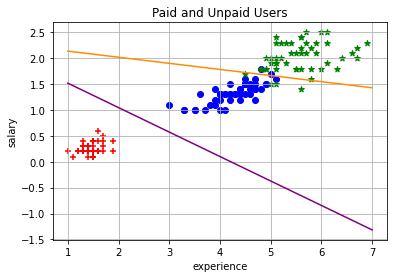

In [83]:
plt.scatter(pl_1,pw_1, color = 'red', marker = '+')
plt.scatter(pl_2,pw_2, color = 'blue', marker = 'o')
plt.scatter(pl_3,pw_3, color = 'green', marker = '*')
# plt.plot(x_db_1, y_db_1, 'purple')
# plt.plot(x_db_2, y_db_2, 'darkorange')
# plt.plot(x_db, y_db, 'purple')
plt.plot(x_db_lst[0], y_db_lst[0], 'purple')
plt.plot(x_db_lst[1], y_db_lst[1], 'darkorange')
plt.xlabel('experience')
plt.ylabel('salary')
# plt.legend()
plt.grid()
plt.title('Paid and Unpaid Users')
plt.show()